# Part II - Dataset Exploration - Ford GoBike System
## by Oladapo Oluwasegun

## Investigation Overview
> The Ford GoBike System is a public bike sharing system in the San Francisco Bay Area, California also called the Bay Wheels. Bay Wheels is the first regional and large-scale bicycle sharing system deployed in California and on the West Coast of the United States with nearly 500,000 rides since the launch in 2017 and had about 10,000 annual subscribers as of January 2018.

> I aim to get a general overview of the dataset and answwer questions relating to bike trips via exploratory & explanatory data analysis & visualizations.


## Dataset Overview
> This data set includes over 180,000 records/information about individual rides made in the bike-sharing system, their monthly individual trip data in February, 2019.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
bike_df = pd.read_csv('fordgobike_tripdata.csv')

bike_df = bike_df.dropna()

time_cols = ['start_time','end_time']
for col in time_cols: 
    bike_df[col] = pd.to_datetime(bike_df[col])
    
# create duration_minute column
bike_df['duration_minute'] = bike_df['duration_sec']/60


# day of week, day and hour
bike_df['start_day'] = bike_df['start_time'].dt.day
bike_df['start_day_of_week'] = bike_df['start_time'].dt.day_name()
bike_df['start_hour'] = bike_df['start_time'].dt.hour
bike_df['end_day'] = bike_df['end_time'].dt.day
bike_df['end_day_of_week'] = bike_df['end_time'].dt.day_name()
bike_df['end_hour'] = bike_df['end_time'].dt.hour

bike_df['age'] = 2019 - bike_df['member_birth_year']

pd.set_option('display.max_columns', None) # Show all datafram columns.
sb.set(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(20,7)})
base_color = sb.color_palette()[0]

ids = bike_df[bike_df['member_gender']=='Other'].index
bike_df = bike_df.drop(index=ids)

ids = bike_df[bike_df['member_birth_year']<1920].index
bike_df = bike_df.drop(index=ids)

unnecessary_cols = ['start_time', 'end_time', 'start_station_id', 'start_station_name','end_station_name','start_station_latitude', 'start_station_longitude',
                    'end_station_id', 'end_station_latitude', 'end_station_longitude','member_birth_year']
bike_df = bike_df.drop(columns=unnecessary_cols,axis=1)

weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdaycat = pd.api.types.CategoricalDtype(ordered=True, categories=weekday)
bike_df['start_day_of_week'] = bike_df['start_day_of_week'].astype(weekdaycat)

def category(age):
    if 10<age<=20:
        return '11-20'
    
    elif 20<age<=30:
        return '21-30'  
    
    elif 30<age<=40:
        return '31-40'
    
    elif 40<age<=50:
        return '41-50'
    
    elif 50<age<=60:
        return '51-60'

bike_df['age_category'] = bike_df['age'].apply(category)

bike_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171234 entries, 0 to 183411
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   duration_sec             171234 non-null  int64   
 1   bike_id                  171234 non-null  int64   
 2   user_type                171234 non-null  object  
 3   member_gender            171234 non-null  object  
 4   bike_share_for_all_trip  171234 non-null  object  
 5   duration_minute          171234 non-null  float64 
 6   start_day                171234 non-null  int64   
 7   start_day_of_week        171234 non-null  category
 8   start_hour               171234 non-null  int64   
 9   end_day                  171234 non-null  int64   
 10  end_day_of_week          171234 non-null  object  
 11  end_hour                 171234 non-null  int64   
 12  age                      171234 non-null  float64 
 13  age_category             167825 non-null  ob

## Proportion of Bike Riders for Members User Type

> There are two types of users in the dataset:
> 1. Subscriber
> 2. Customer

> * In the next visualization I will show the proportion of bike riders for all members user type.

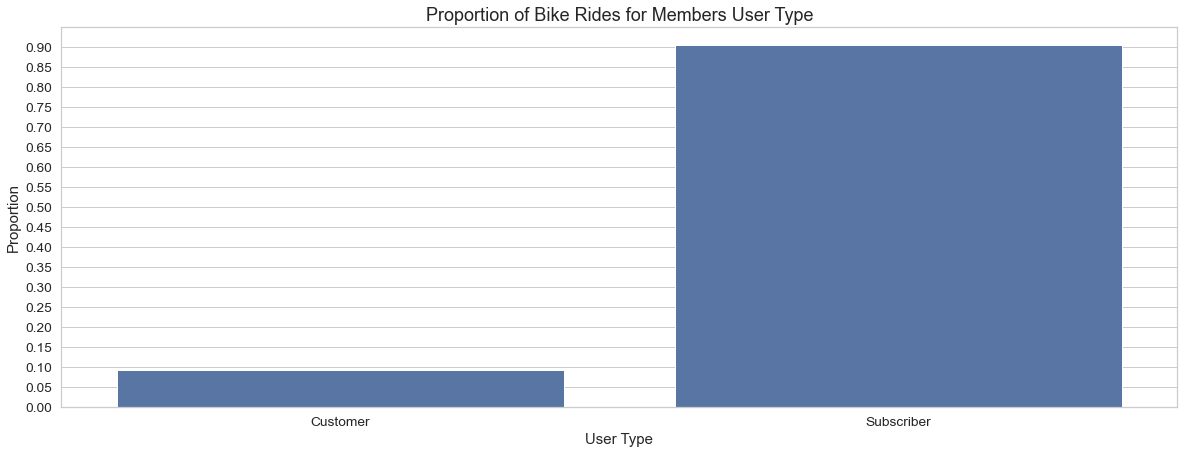

In [3]:
n_points = bike_df.shape[0]

max_count_age = bike_df['user_type'].value_counts().max()
max_prop_age = max_count_age / n_points

tick_props_age = np.arange(0, max_prop_age, 0.05)
tick_names_age = ['{:0.2f}'.format(v) for v in tick_props_age]

sb.countplot(data=bike_df, x='user_type', color=base_color)

ax = plt.gca()
plt.yticks(tick_props_age * n_points, tick_names_age)
ax.set_ylabel('Proportion')
ax.set_xlabel('User Type')
ax.set_title("Proportion of Bike Rides for Members User Type", fontsize=18);

## Daily usage of Bike riders per Gender

> Based o =n my cleaned data, I have two gender, which are **male & female** In the next visualization, I will show the number of bike riders for each day based on gender.

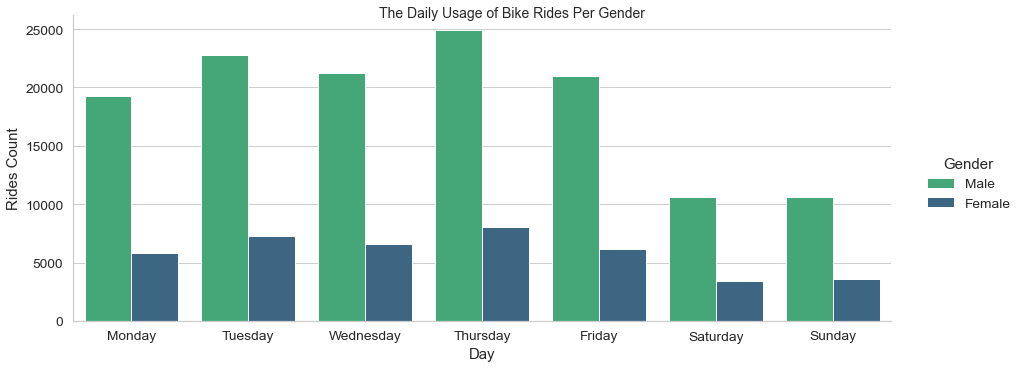

In [4]:
lm = sb.catplot(data=bike_df, x='start_day_of_week', hue='member_gender', kind='count',aspect=20.7/8.27, palette='viridis_r')

lm.set_axis_labels('Day', 'Rides Count')
lm._legend.set_title('Gender')
lm.fig.suptitle('The Daily Usage of Bike Rides Per Gender', fontsize=14);

## Hourly usage of bikes by Customers and Subscribers during the weekdays
> * Different usage patterns happen between the two types of riders.
> * Subscribers used the system heavily on work days i.e. Monday through Friday, whereas customers ride a lot on weekends, especially in the afternoon.
> * Many trips concentrated around 8-9am and 17-18pm on work days for subscribers when used for work commute, yet casual customers tended to use more in the late afternoon around 17pm Monday to Friday.
> * Other than the different usage goals, it may also have to do with the traffic situation around these rush hours in the area.

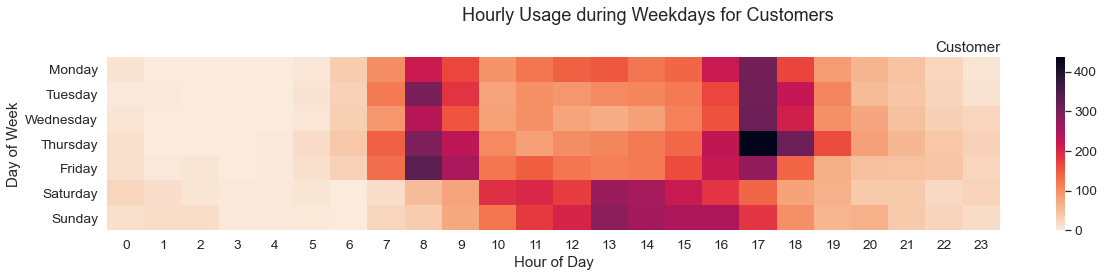

In [27]:
plt.suptitle('Hourly Usage during Weekdays for Customers')

plt.subplot(2, 1, 1)
customers = bike_df.query('user_type == "Customer"')
ct_counts = customers.groupby(['start_day_of_week', 'start_hour']).size()
ct_counts = ct_counts.reset_index(name='count')
ct_counts = ct_counts.pivot(index='start_day_of_week', columns='start_hour', values='count')
sb.heatmap(ct_counts, cmap='rocket_r');
plt.title('Customer', loc='right');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');

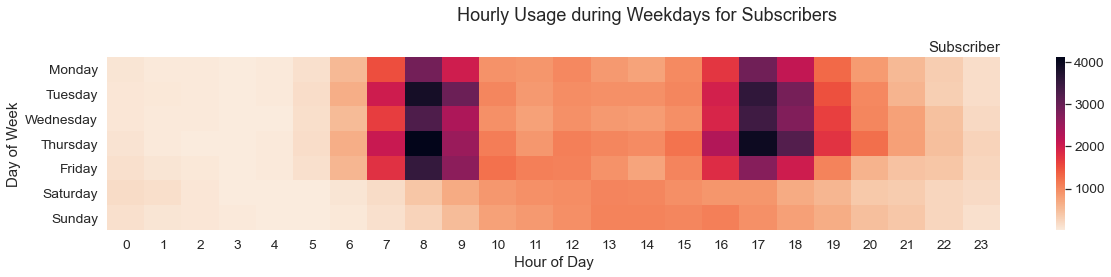

In [26]:
# How does the hourly usage during the weekdays for customers and subscribers?
plt.suptitle('Hourly Usage during Weekdays for Subscribers')

plt.subplot(2, 1, 1)
subscribers = bike_df.query('user_type == "Subscriber"')
st_counts = subscribers.groupby(['start_day_of_week', 'start_hour']).size()
st_counts = st_counts.reset_index(name='count')
st_counts = st_counts.pivot(index='start_day_of_week', columns='start_hour', values='count')
sb.heatmap(st_counts, cmap='rocket_r');
plt.title('Subscriber', loc='right');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');

## Average Weekday Trip Duration for Customers and Subscribers
> * Subscribers ride much shorter/quicker trips compared to customers on each day of the week.
> * Both user types had an obvious increase of trip duration on Saturdays and Sundays (or weekends), especially casual customers.
> * Subscriber usage was more efficient than customers overall and maintained a pretty consistent average duration Monday through Friday.

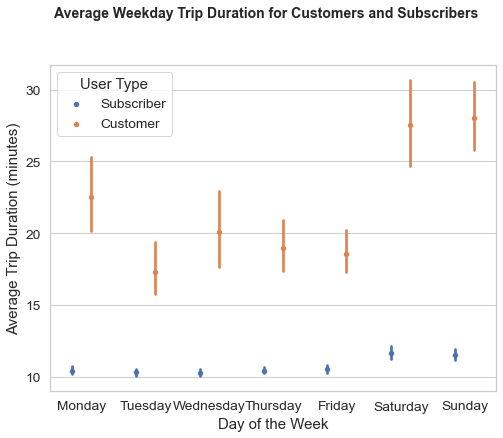

In [6]:
sorted_vals = bike_df.user_type.value_counts()/bike_df.shape[0];

plt.figure(figsize=[8, 6]);
ax = sb.pointplot(data=bike_df, x='start_day_of_week', y='duration_minute', hue='user_type', dodge=0.3, markers='.', linestyles="", hue_order=sorted_vals.index);
ax.legend(title='User Type');
plt.xlabel('Day of the Week');
plt.ylabel('Average Trip Duration (minutes)');
plt.suptitle('Average Weekday Trip Duration for Customers and Subscribers', fontsize=14, fontweight='semibold', y=1.015);

In [ ]:
# Use this command if you are running this file in local
!jupyter nbconvert Ford_GoBike_System_Data_Explanatory_slide_deck.ipynb --to slides --post serve --no-input --no-prompt

### Summary
> * There was a lot more subscribers using the bike sharing system than casual customers overall, with obvious difference in usage patterns and riding habits between the two types of riders. 
> * Subscribers used the system heavily on work days concentrated around 8-9am and 17-18pm for work commute, whereas customers ride a lot over weekends and in the afternoon for leisure/touring purposes.
> * Subscribers tended to have much shorter/quicker trips compared to customers which makes subscriber usage more efficient.